In [233]:
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Importing our survey data

In [234]:
file = Path('Resources/survey_results.xlsx')

results_df = pd.read_excel(file)
#results_df

# Preprocessing

In [235]:
# renaming columns for ease of understanding
survey_df = results_df.rename(columns={
    "ID":"id",
    "Start time": "start_time",
    "Completion time": "end_time",
    "Email": "email",
    "Name": "name",	
    "What is your age range?": "age",
    "Gender":"gender",	
    "Race/Ethnicity (Select all that apply)": "race",	
    "Which US Geographic Region do you live in?": "region",	
    "What is the name of your favorite TV Show?\n": "tv_show",
    "How often do you eat vegetables?": "frequency",
    "Types of veggies you most like to eat (pick your top 5!)": "to_eat",
    'What is your "go to" choice for veggies at home? (Pick your top three)': "at_home",
    'What is your "go to" choice for veggies at a restaurant (top three)': "at_restaurant",	
    "Preferred ways for cooking/preparing the choices you selected above": "cook_prep",
    "What alternative to vegetables do you use/eat to stay healthy?": "alternatives",
    "What are your top three favorite types of fruits you like to eat? (example: apples, bananas, oranges)": "fruits"})
survey_df

,id,start_time,end_time,email,name,age,gender,race,region,tv_show,frequency,to_eat,at_home,at_restaurant,cook_prep,alternatives,fruits
0,1,2022-06-04 15:01:02,2022-06-04 15:05:26,anonymous,NaN,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Firefly,1/week,Asparagus ;Corn;Carrots;Spinach;Broccoli;,Lettuce (any kind);Carrots;Spinach;,Asparagus;Corn;Broccoli;,Grilled;Sauteed;Baked;,NaN,"Cherries, blueberries, pineapple"
1,2,2022-06-06 19:20:23,2022-06-06 19:22:18,anonymous,NaN,20-29,Female,Asian;,Midwest,Vincenzo,4-5/week,Broccoli;Cauliflower;Corn;Green Beans;Peas;Spi...,Broccoli;Corn;Peas;,Broccoli;Cauliflower;Corn;,Fried/Air-fried;Grilled;Sauteed;Microwaved;,NaN,Mangoes cherries oranges
2,3,2022-06-06 19:19:21,2022-06-06 19:22:26,anonymous,NaN,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Ted Lasso,Daily 6-7 week,Broccoli;Carrots;Green Beans;Spinach;Squash;,Broccoli;Carrots;Squash;,Lettuce (any kind);Broccoli;Spinach;,Steamed;Baked;,NaN,"bananas, strawberries, mangos"
3,4,2022-06-06 19:20:24,2022-06-06 19:25:18,anonymous,NaN,20-29,Female,Black or African American;,Midwest,Succession,2-3/week,Broccoli;Carrots;Corn;Green Beans;Cauliflower;,Broccoli;Carrots;Cauliflower;,Broccoli;Carrots;Green Beans;,Baked;Fried/Air-fried;Steamed;,NaN,"Bananas, strawberries, oranges"
4,5,2022-06-06 19:28:42,2022-06-06 19:35:54,anonymous,NaN,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Critical Role,2-3/week,Carrots;Spinach;Squash;Corn;Cauliflower;,Spinach;Carrots;Broccoli;,Spinach;Carrots;Squash;,Baked;Sauteed;,NaN,"Peaches, Oranges, Mangoes"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,157,2022-06-07 15:11:42,2022-06-07 15:13:43,anonymous,NaN,20-29,Female,Asian;,Midwest,90 Day Fiance,Daily 6-7 week,Lettuce (any kind);Spinach;Corn;asparagus;Carr...,Lettuce (any kind);Spinach;Carrots;,brussel sprouts;Spinach;Corn;,Fried/Air-fried;Sauteed;,NaN,"blueberries, strawberries, grapes"
157,158,2022-06-07 15:47:11,2022-06-07 15:51:49,anonymous,NaN,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Gilmore girls,Daily 6-7 week,Spinach;Lettuce (any kind);Carrots;Broccoli;Sq...,Broccoli;Spinach;Lettuce (any kind);,Squash;Spinach;Cauliflower;,Baked;Sauteed;Steamed;,NaN,"Bananas, apples, grapes"
158,159,2022-06-07 15:59:49,2022-06-07 16:03:12,anonymous,NaN,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Chicago Fire,Daily 6-7 week,Lettuce (any kind);Corn;Cauliflower;Carrots;Cu...,Peas;Broccoli;Cauliflower;,Asparagus;,Fried/Air-fried;Grilled;Steamed;,NaN,"Bananas, grapes, apples"
159,160,2022-06-07 16:37:15,2022-06-07 16:39:20,anonymous,NaN,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Bones,2-3/week,Carrots;Corn;Peas;Spinach;Green Beans;,Carrots;Corn;Peas;,Carrots;Green Beans;Spinach;,Steamed;,NaN,"Apples, oranges, pineapple"


In [236]:
# this cell splits columns with multiple answers into their own columns, drops any extra answers beyond what was asked for, and names the new columns
# the result is five baby dataframes

drop_list_five = [0,1,2,3,4]
drop_list_three = [0,1,2]

# SPLIT COLUMNS WITH MULTIPLE SELECTIONS
to_eat_test = survey_df["to_eat"].str.split(';', expand = True)
at_home_test = survey_df["at_home"].str.split(';', expand = True)
at_restaurant_test = survey_df["at_restaurant"].str.split(';', expand = True)
cook_prep_test = survey_df["cook_prep"].str.split(';', expand = True)
fruits_test = survey_df["fruits"].str.split(', ', expand = True)

# drop any columns that come after our drop list
top_to_eat = to_eat_test.drop(to_eat_test.columns.difference(drop_list_five), axis = 1)
top_at_home = at_home_test.drop(at_home_test.columns.difference(drop_list_three), axis = 1)
top_at_restaurant = at_restaurant_test.drop(at_restaurant_test.columns.difference(drop_list_three), axis = 1)
top_cook_prep = cook_prep_test.drop(cook_prep_test.columns.difference(drop_list_three), axis = 1)
top_fruits = fruits_test.drop(fruits_test.columns.difference(drop_list_three), axis = 1)

# rename the new columns
top_to_eat = top_to_eat.rename(columns = {0:"to_eat_1", 1: "to_eat_2", 2: "to_eat_3", 3: "to_eat_4", 4: "to_eat_5"})
top_at_home = top_at_home.rename(columns = {0:"at_home_1", 1: "at_home_2", 2: "at_home_3"})
top_at_restaurant = top_at_restaurant.rename(columns = {0:"at_restaurant_1", 1: "at_restaurant_2", 2: "at_restaurant_3"})
top_cook_prep = top_cook_prep.rename(columns = {0:"cook_prep_1", 1: "cook_prep_2", 2: "cook_prep_3"})
top_fruits = top_fruits.rename(columns = {0:"fruits_1", 1: "fruits_2", 2: "fruits_3"})

In [237]:
# creating a list of new dataframes
df_list = [top_to_eat, top_at_home, top_at_restaurant,top_cook_prep, top_fruits]
# pd.merge(pd.merge(top_to_eat,top_at_home,on='id'),top_at_restaurant,on='id')

# merging the five new dataframes into one new dataframe
df = df_list[0]
for df_ in df_list[1:]:
    df = df.merge(df_, left_index=True, right_index=True)

# adding this new dataframe back into survey_df 
for column in df:
     
    # Select column conents by column
    # name using [] operator
    survey_df[column] = df[column]

print(survey_df.keys())

Index(['id', 'start_time', 'end_time', 'email', 'name', 'age', 'gender',
       'race', 'region', 'tv_show', 'frequency', 'to_eat', 'at_home',
       'at_restaurant', 'cook_prep', 'alternatives', 'fruits', 'to_eat_1',
       'to_eat_2', 'to_eat_3', 'to_eat_4', 'to_eat_5', 'at_home_1',
       'at_home_2', 'at_home_3', 'at_restaurant_1', 'at_restaurant_2',
       'at_restaurant_3', 'cook_prep_1', 'cook_prep_2', 'cook_prep_3',
       'fruits_1', 'fruits_2', 'fruits_3'],
      dtype='object')


In [238]:
# dropping non-beneficial columns
survey_df.drop(['id', 'start_time', 'end_time', 'email', 'name', 'alternatives', 'to_eat', 'at_home', 'at_restaurant','cook_prep', 'fruits'], axis=1, inplace=True)
survey_df

,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,to_eat_4,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Firefly,1/week,Asparagus,Corn,Carrots,Spinach,...,Spinach,Asparagus,Corn,Broccoli,Grilled,Sauteed,Baked,Cherries,blueberries,pineapple
1,20-29,Female,Asian;,Midwest,Vincenzo,4-5/week,Broccoli,Cauliflower,Corn,Green Beans,...,Peas,Broccoli,Cauliflower,Corn,Fried/Air-fried,Grilled,Sauteed,Mangoes cherries oranges,None,None
2,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Ted Lasso,Daily 6-7 week,Broccoli,Carrots,Green Beans,Spinach,...,Squash,Lettuce (any kind),Broccoli,Spinach,Steamed,Baked,,bananas,strawberries,mangos
3,20-29,Female,Black or African American;,Midwest,Succession,2-3/week,Broccoli,Carrots,Corn,Green Beans,...,Cauliflower,Broccoli,Carrots,Green Beans,Baked,Fried/Air-fried,Steamed,Bananas,strawberries,oranges
4,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Critical Role,2-3/week,Carrots,Spinach,Squash,Corn,...,Broccoli,Spinach,Carrots,Squash,Baked,Sauteed,,Peaches,Oranges,Mangoes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,20-29,Female,Asian;,Midwest,90 Day Fiance,Daily 6-7 week,Lettuce (any kind),Spinach,Corn,asparagus,...,Carrots,brussel sprouts,Spinach,Corn,Fried/Air-fried,Sauteed,,blueberries,strawberries,grapes
157,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Gilmore girls,Daily 6-7 week,Spinach,Lettuce (any kind),Carrots,Broccoli,...,Lettuce (any kind),Squash,Spinach,Cauliflower,Baked,Sauteed,Steamed,Bananas,apples,grapes
158,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Chicago Fire,Daily 6-7 week,Lettuce (any kind),Corn,Cauliflower,Carrots,...,Cauliflower,Asparagus,,None,Fried/Air-fried,Grilled,Steamed,Bananas,grapes,apples
159,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Bones,2-3/week,Carrots,Corn,Peas,Spinach,...,Peas,Carrots,Green Beans,Spinach,Steamed,,None,Apples,oranges,pineapple


In [239]:
# capitalizing all values
survey_df = survey_df.apply(lambda x: x.astype(str).str.upper())
survey_df

,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,to_eat_4,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,FIREFLY,1/WEEK,ASPARAGUS,CORN,CARROTS,SPINACH,...,SPINACH,ASPARAGUS,CORN,BROCCOLI,GRILLED,SAUTEED,BAKED,CHERRIES,BLUEBERRIES,PINEAPPLE
1,20-29,FEMALE,ASIAN;,MIDWEST,VINCENZO,4-5/WEEK,BROCCOLI,CAULIFLOWER,CORN,GREEN BEANS,...,PEAS,BROCCOLI,CAULIFLOWER,CORN,FRIED/AIR-FRIED,GRILLED,SAUTEED,MANGOES CHERRIES ORANGES,NONE,NONE
2,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,TED LASSO,DAILY 6-7 WEEK,BROCCOLI,CARROTS,GREEN BEANS,SPINACH,...,SQUASH,LETTUCE (ANY KIND),BROCCOLI,SPINACH,STEAMED,BAKED,,BANANAS,STRAWBERRIES,MANGOS
3,20-29,FEMALE,BLACK OR AFRICAN AMERICAN;,MIDWEST,SUCCESSION,2-3/WEEK,BROCCOLI,CARROTS,CORN,GREEN BEANS,...,CAULIFLOWER,BROCCOLI,CARROTS,GREEN BEANS,BAKED,FRIED/AIR-FRIED,STEAMED,BANANAS,STRAWBERRIES,ORANGES
4,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CRITICAL ROLE,2-3/WEEK,CARROTS,SPINACH,SQUASH,CORN,...,BROCCOLI,SPINACH,CARROTS,SQUASH,BAKED,SAUTEED,,PEACHES,ORANGES,MANGOES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,20-29,FEMALE,ASIAN;,MIDWEST,90 DAY FIANCE,DAILY 6-7 WEEK,LETTUCE (ANY KIND),SPINACH,CORN,ASPARAGUS,...,CARROTS,BRUSSEL SPROUTS,SPINACH,CORN,FRIED/AIR-FRIED,SAUTEED,,BLUEBERRIES,STRAWBERRIES,GRAPES
157,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,GILMORE GIRLS,DAILY 6-7 WEEK,SPINACH,LETTUCE (ANY KIND),CARROTS,BROCCOLI,...,LETTUCE (ANY KIND),SQUASH,SPINACH,CAULIFLOWER,BAKED,SAUTEED,STEAMED,BANANAS,APPLES,GRAPES
158,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CHICAGO FIRE,DAILY 6-7 WEEK,LETTUCE (ANY KIND),CORN,CAULIFLOWER,CARROTS,...,CAULIFLOWER,ASPARAGUS,,NONE,FRIED/AIR-FRIED,GRILLED,STEAMED,BANANAS,GRAPES,APPLES
159,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,BONES,2-3/WEEK,CARROTS,CORN,PEAS,SPINACH,...,PEAS,CARROTS,GREEN BEANS,SPINACH,STEAMED,,NONE,APPLES,ORANGES,PINEAPPLE


In [240]:
# doing some manual cleaning
survey_df['fruits_1'] = survey_df['fruits_1'].replace(
    ['BANANA', 'MANGO', 'MANGOES', 'STRAWBERRY', 'APPLE', 'BLUE BERRIES', 'BLUEBERRY', 'PEACH', 'APPLE’S', ' APPLES', 'ORANGE', 'PEAR', 'CLEMENTINE', 'MANDERIN ORANGES', 'TANGERINES', 'RAINER CHERRIES', 'RED GRAPES', 'CLEMENTINES', 'RASPBERRY ', '(NAVEL) ORANGES'], 
    ['BANANAS', 'MANGOS', 'MANGOS', 'STRAWBERRIES', 'APPLES', 'BLUEBERRIES', 'BLUEBERRIES', 'PEACHES', 'APPLES', 'APPLES', 'ORANGES', 'PEARS', 'ORANGES', 'ORANGES', 'ORANGES', 'CHERRIES', 'GRAPES', 'ORANGES', 'RASPBERRIES', 'ORANGES'])

survey_df['fruits_2'] = survey_df['fruits_2'].replace(
    ['BANANA', 'MANGO', 'MANGOES', 'STRAWBERRY', 'APPLE', 'BLUE BERRIES', 'BLUEBERRY', 'PEACH', 'APPLE’S', ' APPLES', 'ORANGE', 'PEAR', 'CLEMENTINE', 'MANDERIN ORANGES', 'TANGERINES', 'RAINER CHERRIES', 'RED GRAPES', 'CLEMENTINES', 'RASPBERRY ', '(NAVEL) ORANGES'], 
    ['BANANAS', 'MANGOS', 'MANGOS', 'STRAWBERRIES', 'APPLES', 'BLUEBERRIES', 'BLUEBERRIES', 'PEACHES', 'APPLES', 'APPLES', 'ORANGES', 'PEARS', 'ORANGES', 'ORANGES', 'ORANGES', 'CHERRIES', 'GRAPES', 'ORANGES', 'RASPBERRIES', 'ORANGES'])

survey_df['fruits_3'] = survey_df['fruits_3'].replace(
    ['BANANA', 'MANGO', 'MANGOES', 'STRAWBERRY', 'APPLE', 'BLUE BERRIES', 'BLUEBERRY', 'PEACH', 'APPLE’S', ' APPLES', 'ORANGE', 'PEAR', 'CLEMENTINE', 'MANDERIN ORANGES', 'TANGERINES', 'RAINER CHERRIES', 'RED GRAPES', 'CLEMENTINES', 'RASPBERRY ', '(NAVEL) ORANGES'], 
    ['BANANAS', 'MANGOS', 'MANGOS', 'STRAWBERRIES', 'APPLES', 'BLUEBERRIES', 'BLUEBERRIES', 'PEACHES', 'APPLES', 'APPLES', 'ORANGES', 'PEARS', 'ORANGES', 'ORANGES', 'ORANGES', 'CHERRIES', 'GRAPES', 'ORANGES', 'RASPBERRIES', 'ORANGES'])


In [241]:
# determine the number of unique values in each column
survey_cat = survey_df.dtypes.index.tolist()
survey_df[survey_cat].nunique()

age                  7
gender               3
race                11
region               9
tv_show            118
frequency            5
to_eat_1            13
to_eat_2            12
to_eat_3            15
to_eat_4            24
to_eat_5            28
at_home_1           17
at_home_2           16
at_home_3           23
at_restaurant_1     19
at_restaurant_2     16
at_restaurant_3     24
cook_prep_1         10
cook_prep_2         10
cook_prep_3         11
fruits_1            42
fruits_2            43
fruits_3            44
dtype: int64

In [242]:
# look at fruits_1 value counts for binning
fruits_1_count = survey_df['fruits_1'].value_counts()
fruits_1_count

APPLES                                29
BANANAS                               29
STRAWBERRIES                          15
BLUEBERRIES                           12
MANGOS                                11
ORANGES                                9
GRAPES                                 7
BLACKBERRIES                           4
PINEAPPLE                              4
WATERMELON                             3
CHERRIES                               3
BERRIES                                3
PEACHES                                2
RASPBERRIES                            2
GRAPES,WATERMELON,STRAWBERRY           1
GRAPEFRUIT                             1
STRAWBERRIES PINEAPPLE PEACHES         1
STRAWBERRY,WATERMELON,GRAPES           1
KIWI                                   1
MELON                                  1
NONE                                   1
GRAPEFRUIT APPLES GRAPES               1
APPLE                                  1
PINEAPPLE MANGO GRAPES                 1
BANANAS STRAWBER

In [243]:
# bin all the fruits that have just 1 response together into "other"
fruits_1_to_replace = list(fruits_1_count[fruits_1_count == 1].index)

# replace in dataframe
for fruit in fruits_1_to_replace:
    survey_df['fruits_1'] = survey_df['fruits_1'].replace(fruit, "OTHER")

# check to make sure binning was successful
survey_df['fruits_1'].value_counts()

BANANAS         29
APPLES          29
OTHER           28
STRAWBERRIES    15
BLUEBERRIES     12
MANGOS          11
ORANGES          9
GRAPES           7
BLACKBERRIES     4
PINEAPPLE        4
CHERRIES         3
WATERMELON       3
BERRIES          3
PEACHES          2
RASPBERRIES      2
Name: fruits_1, dtype: int64

In [244]:
# look at fruits_2 value counts for binning
fruits_2_count = survey_df['fruits_2'].value_counts()
fruits_2_count.head(30)

NONE                       23
GRAPES                     16
BANANAS                    15
STRAWBERRIES               13
ORANGES                    11
BLUEBERRIES                10
APPLES                     10
MANGOS                      9
PINEAPPLE                   5
RASPBERRIES                 5
WATERMELON                  5
PEACHES                     3
PEARS                       3
GRAPEFRUIT                  2
CHERRIES                    2
CANTELOPE                   2
LYNCHES AND JACK FRUIT      1
BLUEBERRIES. BANANAS        1
PLUMS                       1
CITRUS                      1
BERRIES                     1
MELON                       1
HONEYDEW (ANY) MELONS       1
TOMATOES                    1
AVOCADO                     1
GRAPES,APPLES               1
PAPAYA                      1
BLACKBERRY                  1
CANTALOUPE                  1
BLUEBERRIES,APPLES          1
Name: fruits_2, dtype: int64

In [245]:
# bin all the fruits that have just 1 response together into "other"
fruits_2_to_replace = list(fruits_2_count[fruits_2_count == 1].index)

# replace in dataframe
for fruit in fruits_2_to_replace:
    survey_df['fruits_2'] = survey_df['fruits_2'].replace(fruit, "OTHER")

# check to make sure binning was successful
survey_df['fruits_2'].value_counts()

OTHER           27
NONE            23
GRAPES          16
BANANAS         15
STRAWBERRIES    13
ORANGES         11
BLUEBERRIES     10
APPLES          10
MANGOS           9
PINEAPPLE        5
RASPBERRIES      5
WATERMELON       5
PEARS            3
PEACHES          3
GRAPEFRUIT       2
CHERRIES         2
CANTELOPE        2
Name: fruits_2, dtype: int64

In [246]:
# look at fruits_3 value counts for binning
fruits_3_count = survey_df['fruits_3'].value_counts()
fruits_3_count.head(30)

NONE             32
GRAPES           17
BANANAS          13
APPLES           12
ORANGES           9
STRAWBERRIES      7
PINEAPPLE         5
WATERMELON        5
KIWI              5
PEACHES           4
RASPBERRIES       4
BLUEBERRIES       4
STRAWBERRIES      3
MANGOS            3
WATERMELON        3
BLACKBERRIES      2
GRAPES            2
ORANGES           2
BLUEBERRIES       2
CHERRIES          2
BERRIES           2
POMEGRANATES      1
CANTELOPE         1
AND BANANA        1
 WATERMELON       1
NECTARINES        1
LIMES             1
CHERRIES          1
MELON             1
BANANA            1
Name: fruits_3, dtype: int64

In [247]:
# bin all the fruits that have just 1 response together into "other"
fruits_3_to_replace = list(fruits_3_count[fruits_3_count == 1].index)

# replace in dataframe
for fruit in fruits_3_to_replace:
    survey_df['fruits_3'] = survey_df['fruits_3'].replace(fruit, "OTHER")

# check to make sure binning was successful
survey_df['fruits_3'].value_counts()

NONE             32
OTHER            23
GRAPES           17
BANANAS          13
APPLES           12
ORANGES           9
STRAWBERRIES      7
WATERMELON        5
KIWI              5
PINEAPPLE         5
BLUEBERRIES       4
RASPBERRIES       4
PEACHES           4
WATERMELON        3
STRAWBERRIES      3
MANGOS            3
BLACKBERRIES      2
ORANGES           2
CHERRIES          2
BERRIES           2
BLUEBERRIES       2
GRAPES            2
Name: fruits_3, dtype: int64

In [248]:
survey_df

,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,to_eat_4,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,FIREFLY,1/WEEK,ASPARAGUS,CORN,CARROTS,SPINACH,...,SPINACH,ASPARAGUS,CORN,BROCCOLI,GRILLED,SAUTEED,BAKED,CHERRIES,BLUEBERRIES,OTHER
1,20-29,FEMALE,ASIAN;,MIDWEST,VINCENZO,4-5/WEEK,BROCCOLI,CAULIFLOWER,CORN,GREEN BEANS,...,PEAS,BROCCOLI,CAULIFLOWER,CORN,FRIED/AIR-FRIED,GRILLED,SAUTEED,OTHER,NONE,NONE
2,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,TED LASSO,DAILY 6-7 WEEK,BROCCOLI,CARROTS,GREEN BEANS,SPINACH,...,SQUASH,LETTUCE (ANY KIND),BROCCOLI,SPINACH,STEAMED,BAKED,,BANANAS,STRAWBERRIES,MANGOS
3,20-29,FEMALE,BLACK OR AFRICAN AMERICAN;,MIDWEST,SUCCESSION,2-3/WEEK,BROCCOLI,CARROTS,CORN,GREEN BEANS,...,CAULIFLOWER,BROCCOLI,CARROTS,GREEN BEANS,BAKED,FRIED/AIR-FRIED,STEAMED,BANANAS,STRAWBERRIES,ORANGES
4,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CRITICAL ROLE,2-3/WEEK,CARROTS,SPINACH,SQUASH,CORN,...,BROCCOLI,SPINACH,CARROTS,SQUASH,BAKED,SAUTEED,,PEACHES,ORANGES,MANGOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,20-29,FEMALE,ASIAN;,MIDWEST,90 DAY FIANCE,DAILY 6-7 WEEK,LETTUCE (ANY KIND),SPINACH,CORN,ASPARAGUS,...,CARROTS,BRUSSEL SPROUTS,SPINACH,CORN,FRIED/AIR-FRIED,SAUTEED,,BLUEBERRIES,STRAWBERRIES,GRAPES
157,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,GILMORE GIRLS,DAILY 6-7 WEEK,SPINACH,LETTUCE (ANY KIND),CARROTS,BROCCOLI,...,LETTUCE (ANY KIND),SQUASH,SPINACH,CAULIFLOWER,BAKED,SAUTEED,STEAMED,BANANAS,APPLES,GRAPES
158,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CHICAGO FIRE,DAILY 6-7 WEEK,LETTUCE (ANY KIND),CORN,CAULIFLOWER,CARROTS,...,CAULIFLOWER,ASPARAGUS,,NONE,FRIED/AIR-FRIED,GRILLED,STEAMED,BANANAS,GRAPES,APPLES
159,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,BONES,2-3/WEEK,CARROTS,CORN,PEAS,SPINACH,...,PEAS,CARROTS,GREEN BEANS,SPINACH,STEAMED,,NONE,APPLES,ORANGES,PINEAPPLE


In [249]:
# re-look at the number of unique values in each column now that the fruits have been binned
survey_cat = survey_df.dtypes.index.tolist()
survey_df[survey_cat].nunique()

age                  7
gender               3
race                11
region               9
tv_show            118
frequency            5
to_eat_1            13
to_eat_2            12
to_eat_3            15
to_eat_4            24
to_eat_5            28
at_home_1           17
at_home_2           16
at_home_3           23
at_restaurant_1     19
at_restaurant_2     16
at_restaurant_3     24
cook_prep_1         10
cook_prep_2         10
cook_prep_3         11
fruits_1            15
fruits_2            17
fruits_3            22
dtype: int64

In [250]:
# make sure there are no null values
for column in survey_df.columns:
    print(f"Column {column} has {survey_df[column].isnull().sum()} null values")

Column age has 0 null values
Column gender has 0 null values
Column race has 0 null values
Column region has 0 null values
Column tv_show has 0 null values
Column frequency has 0 null values
Column to_eat_1 has 0 null values
Column to_eat_2 has 0 null values
Column to_eat_3 has 0 null values
Column to_eat_4 has 0 null values
Column to_eat_5 has 0 null values
Column at_home_1 has 0 null values
Column at_home_2 has 0 null values
Column at_home_3 has 0 null values
Column at_restaurant_1 has 0 null values
Column at_restaurant_2 has 0 null values
Column at_restaurant_3 has 0 null values
Column cook_prep_1 has 0 null values
Column cook_prep_2 has 0 null values
Column cook_prep_3 has 0 null values
Column fruits_1 has 0 null values
Column fruits_2 has 0 null values
Column fruits_3 has 0 null values


## Should we add "NaN" to the blank cells? I'm not sure how...

In [251]:
# look at gender value counts 
gender_count = survey_df['gender'].value_counts()
gender_count

FEMALE    125
MALE       35
TREE        1
Name: gender, dtype: int64

In [252]:
# transform the gender column
def changeStatus(status):
    if status == "FEMALE":
        return 1
    if status == "MALE":
        return 0
    else:
        return 3

# Along with replace() and map(), this is another way to encode the gender column into numbers.
survey_df["gender"] = survey_df["gender"].apply(changeStatus)
survey_df

,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,to_eat_4,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,40-49,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,FIREFLY,1/WEEK,ASPARAGUS,CORN,CARROTS,SPINACH,...,SPINACH,ASPARAGUS,CORN,BROCCOLI,GRILLED,SAUTEED,BAKED,CHERRIES,BLUEBERRIES,OTHER
1,20-29,1,ASIAN;,MIDWEST,VINCENZO,4-5/WEEK,BROCCOLI,CAULIFLOWER,CORN,GREEN BEANS,...,PEAS,BROCCOLI,CAULIFLOWER,CORN,FRIED/AIR-FRIED,GRILLED,SAUTEED,OTHER,NONE,NONE
2,40-49,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,TED LASSO,DAILY 6-7 WEEK,BROCCOLI,CARROTS,GREEN BEANS,SPINACH,...,SQUASH,LETTUCE (ANY KIND),BROCCOLI,SPINACH,STEAMED,BAKED,,BANANAS,STRAWBERRIES,MANGOS
3,20-29,1,BLACK OR AFRICAN AMERICAN;,MIDWEST,SUCCESSION,2-3/WEEK,BROCCOLI,CARROTS,CORN,GREEN BEANS,...,CAULIFLOWER,BROCCOLI,CARROTS,GREEN BEANS,BAKED,FRIED/AIR-FRIED,STEAMED,BANANAS,STRAWBERRIES,ORANGES
4,30-39,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CRITICAL ROLE,2-3/WEEK,CARROTS,SPINACH,SQUASH,CORN,...,BROCCOLI,SPINACH,CARROTS,SQUASH,BAKED,SAUTEED,,PEACHES,ORANGES,MANGOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,20-29,1,ASIAN;,MIDWEST,90 DAY FIANCE,DAILY 6-7 WEEK,LETTUCE (ANY KIND),SPINACH,CORN,ASPARAGUS,...,CARROTS,BRUSSEL SPROUTS,SPINACH,CORN,FRIED/AIR-FRIED,SAUTEED,,BLUEBERRIES,STRAWBERRIES,GRAPES
157,30-39,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,GILMORE GIRLS,DAILY 6-7 WEEK,SPINACH,LETTUCE (ANY KIND),CARROTS,BROCCOLI,...,LETTUCE (ANY KIND),SQUASH,SPINACH,CAULIFLOWER,BAKED,SAUTEED,STEAMED,BANANAS,APPLES,GRAPES
158,40-49,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CHICAGO FIRE,DAILY 6-7 WEEK,LETTUCE (ANY KIND),CORN,CAULIFLOWER,CARROTS,...,CAULIFLOWER,ASPARAGUS,,NONE,FRIED/AIR-FRIED,GRILLED,STEAMED,BANANAS,GRAPES,APPLES
159,30-39,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,BONES,2-3/WEEK,CARROTS,CORN,PEAS,SPINACH,...,PEAS,CARROTS,GREEN BEANS,SPINACH,STEAMED,,NONE,APPLES,ORANGES,PINEAPPLE


In [253]:
survey_df_columns = survey_df.columns.values.tolist()
survey_df_columns.remove('gender')
survey_df_columns

['age',
 'race',
 'region',
 'tv_show',
 'frequency',
 'to_eat_1',
 'to_eat_2',
 'to_eat_3',
 'to_eat_4',
 'to_eat_5',
 'at_home_1',
 'at_home_2',
 'at_home_3',
 'at_restaurant_1',
 'at_restaurant_2',
 'at_restaurant_3',
 'cook_prep_1',
 'cook_prep_2',
 'cook_prep_3',
 'fruits_1',
 'fruits_2',
 'fruits_3']

In [254]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_survey_df = pd.get_dummies(survey_df)
numeric_survey_df

,gender,age_10 AND UNDER,age_11-19,age_20-29,age_30-39,age_40-49,age_50-65,age_OVER 65,race_AFRICAN;,race_ASIAN;,...,fruits_3_ORANGES,fruits_3_ORANGES,fruits_3_OTHER,fruits_3_PEACHES,fruits_3_PINEAPPLE,fruits_3_RASPBERRIES,fruits_3_STRAWBERRIES,fruits_3_STRAWBERRIES,fruits_3_WATERMELON,fruits_3_WATERMELON
0,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
157,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [255]:
# survey_df['age'] = survey_df['age'].astype('float128')

In [256]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(numeric_survey_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,2872.024845
1,2,2756.915132
2,3,2689.750337
3,4,2650.895849
4,5,2630.727546


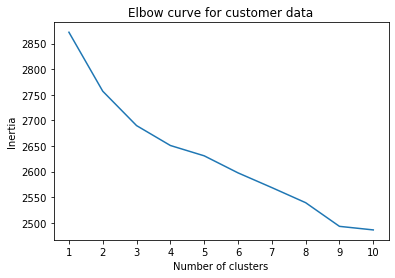

In [257]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [258]:
# get_clusters function
model = KMeans(n_clusters=3, random_state=0)
model.fit(numeric_survey_df)
predictions = model.predict(numeric_survey_df)
numeric_survey_df_classed = numeric_survey_df
numeric_survey_df_classed

,gender,age_10 AND UNDER,age_11-19,age_20-29,age_30-39,age_40-49,age_50-65,age_OVER 65,race_AFRICAN;,race_ASIAN;,...,fruits_3_ORANGES,fruits_3_ORANGES,fruits_3_OTHER,fruits_3_PEACHES,fruits_3_PINEAPPLE,fruits_3_RASPBERRIES,fruits_3_STRAWBERRIES,fruits_3_STRAWBERRIES,fruits_3_WATERMELON,fruits_3_WATERMELON
0,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
157,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [259]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [260]:
clusters = get_clusters(3, numeric_survey_df)
clusters

,gender,age_10 AND UNDER,age_11-19,age_20-29,age_30-39,age_40-49,age_50-65,age_OVER 65,race_AFRICAN;,race_ASIAN;,...,fruits_3_ORANGES,fruits_3_OTHER,fruits_3_PEACHES,fruits_3_PINEAPPLE,fruits_3_RASPBERRIES,fruits_3_STRAWBERRIES,fruits_3_STRAWBERRIES,fruits_3_WATERMELON,fruits_3_WATERMELON,class
0,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
157,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [261]:
def show_clusters(df):
    plt.scatter(df['Annual Income'], df['Spending Score'], c=df['class'])
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.show()

show_clusters(clusters)

KeyError: 'Annual Income'

In [ ]:
for k in range(1, 10):
    show_clusters(get_clusters(k, numeric_survey_df))

# Categorizing the TV Shows into genres using TheMovieDB API

In [ ]:
# #Dependencies for API
# import requests
# import json

# from api_key import movie_api

In [ ]:
# shows = survey_df["tv_show"].tolist()
# print(shows)

In [ ]:
# movie_url = "https://api.themoviedb.org/3/search/movie?api_key="+movie_api

# ids = []
# titles = []
# genre_id = []
# test = []

# for movie in broken:
#     search = requests.get(movie_url + "&query="+movie).json()
#     # search = requests.get(movie_url + "&query= CRITICAL ROLE").json()
#     try:
#         movie_id = search['results'][0]['id']
#         titles.append(movie)
#         print(search['results'][0])
#         # cast_url = "https://api.themoviedb.org/3/movie/"+str(movie_id)+"/credits?api_key="+movie_api
#         # response = requests.get(cast_url).json()
    
#         # char_count.append(len(response['cast']))
    
#         #Pulls character list for each movie and adds the movie id into the 'ids' list
#         # for i in range(0,(len(response['cast']))):

#         #     chars.append(response['cast'][i]['character'])
#         #     ids.append(movie_id)
#         #     titles.append(movie)
#         # print(movie)
        
            
#     except:
#         print(f"'{movie}' failed again")